# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, its time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:
* Use modified sampling techniques to address class imbalance problems
* Understand the complications of class imbalance problems

## Predicting Credit Card Fraud
Load the **creditcard.csv.gz** file and preview the data. To load a compressed csv use the optional parameter compression='gzip' within pandas read_csv method as in: `pd.read_csv(filename, compression='gzip')`.

In [1]:
import pandas as pd
df = pd.read_csv('creditcard.csv.gz',compression='gzip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preview the class imbalance

You should see that the dataset has 31 columns. The first is a time field followed by V1-V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary Class flag. This last column, Class, is the indication of whether or not the purchase was fraudulent, and it is the feature you should be attempting to predict.

Take a look at how imbalanced this dataset is.

In [2]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Define the Problem

Define X and y and perform a standard train test split.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
y = df.Class
X = df[df.columns.difference(['Class'])]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [6]:
pd.Series(y_train).value_counts()

0    227449
1       396
Name: Class, dtype: int64

## Create an initial model

As a baseline, fit a cookie cutter out of the box logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

In [10]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

logreg = LogisticRegression(fit_intercept=False, C=1e12)

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


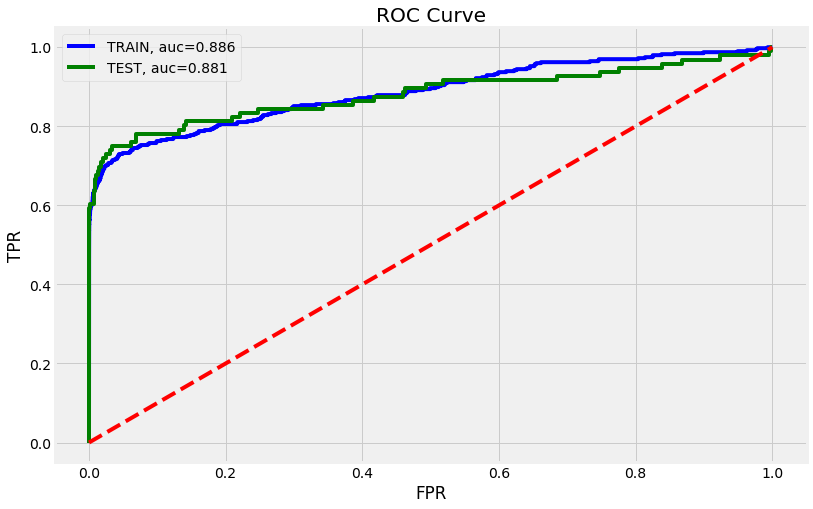

Confusion Matrix Train: 


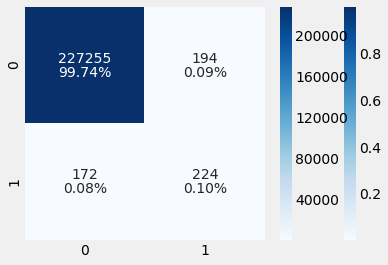

Confusion Matrix Test: 


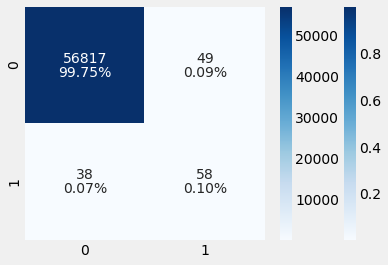

In [11]:
logreg.fit(X_train,y_train)

#ROC & AUC Train
y_score_train = logreg.decision_function(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_score_train)
auc_train = auc(fpr_train,tpr_train)

#ROC & AUC Test
y_score_test = logreg.decision_function(X_test)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_score_test)
auc_test = auc(fpr_test,tpr_test)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')
plt.plot(fpr_train, tpr_train, color='blue', label='TRAIN, auc='+str(round(auc_train,3)))
plt.plot(fpr_test, tpr_test, color='green', label='TEST, auc='+str(round(auc_test,3)))
plt.plot([0,1],[0,1],color='red',linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

y_train_pred = logreg.predict(X_train)
cf_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix Train: ")
akws = {"ha": 'center',"va": 'top'}
sns.heatmap(cf_train/(np.sum(cf_train)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws)

akws = {"ha": 'center',"va": 'bottom'}
sns.heatmap(cf_train,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
plt.show()

y_test_pred = logreg.predict(X_test)
cf_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix Test: ")
akws = {"ha": 'center',"va": 'top'}
sns.heatmap(cf_test/(np.sum(cf_test)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws)

akws = {"ha": 'center',"va": 'bottom'}
sns.heatmap(cf_test,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
plt.show()

## Tuning 
Try some of the various techniques proposed to tune your model. Compare your models using AUC, ROC or another metric.

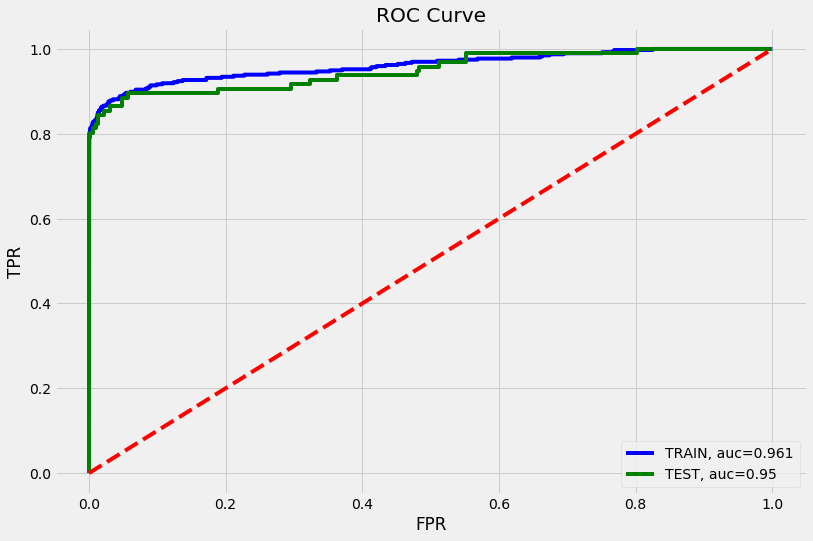

Confusion Matrix Train: 


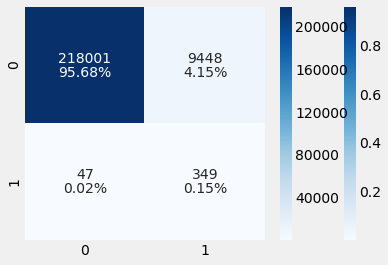

Confusion Matrix Test: 


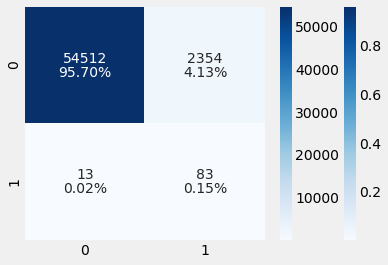

In [12]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, class_weight='balanced', solver='lbfgs')
logreg.fit(X_train,y_train)

#ROC & AUC Train
y_score_train = logreg.decision_function(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_score_train)
auc_train = auc(fpr_train,tpr_train)

#ROC & AUC Test
y_score_test = logreg.decision_function(X_test)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_score_test)
auc_test = auc(fpr_test,tpr_test)

plt.figure(figsize=(12,8))
plt.plot(fpr_train, tpr_train, color='blue', label='TRAIN, auc='+str(round(auc_train,3)))
plt.plot(fpr_test, tpr_test, color='green', label='TEST, auc='+str(round(auc_test,3)))
plt.plot([0,1],[0,1],color='red',linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

y_train_pred = logreg.predict(X_train)
cf_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix Train: ")
akws = {"ha": 'center',"va": 'top'}
sns.heatmap(cf_train/(np.sum(cf_train)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws)

akws = {"ha": 'center',"va": 'bottom'}
sns.heatmap(cf_train,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
plt.show()

y_test_pred = logreg.predict(X_test)
cf_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix Test: ")
akws = {"ha": 'center',"va": 'top'}
sns.heatmap(cf_test/(np.sum(cf_test)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws)

akws = {"ha": 'center',"va": 'bottom'}
sns.heatmap(cf_test,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
plt.show()

### SMOTE
If you haven't already, try using the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [14]:
X_train_resampled, y_train_resampled = smote.fit_sample(X_train,y_train)

In [15]:
pd.Series(y_train_resampled).value_counts()

1    227449
0    227449
dtype: int64

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


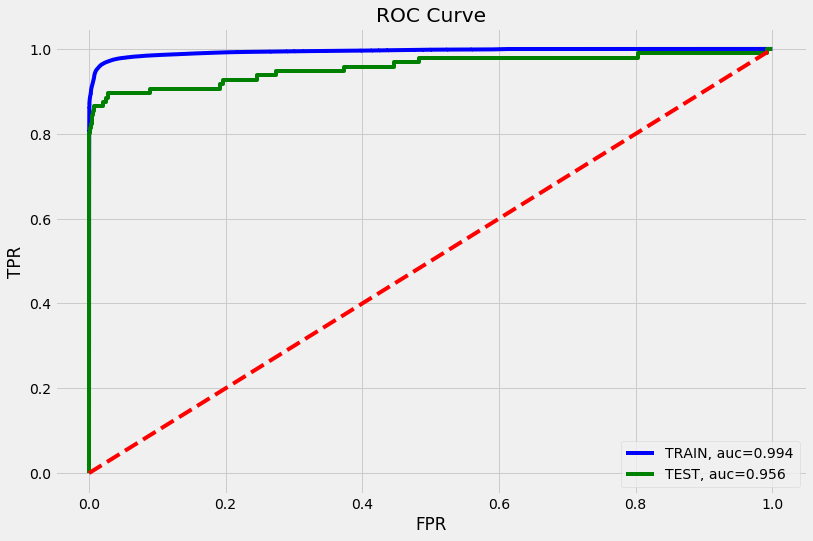

Confusion Matrix Train Resampled: 


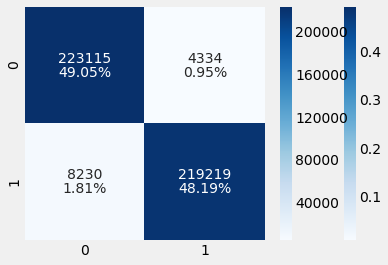

Confusion Matrix Test: 


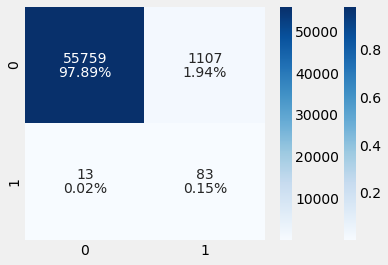

In [16]:
logreg = LogisticRegression(fit_intercept=False, C=1e12)
logreg.fit(X_train_resampled,y_train_resampled)

#ROC & AUC Train
y_score_train = logreg.decision_function(X_train_resampled)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_resampled,y_score_train)
auc_train = auc(fpr_train,tpr_train)

#ROC & AUC Test
y_score_test = logreg.decision_function(X_test)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_score_test)
auc_test = auc(fpr_test,tpr_test)

plt.figure(figsize=(12,8))
plt.plot(fpr_train, tpr_train, color='blue', label='TRAIN, auc='+str(round(auc_train,3)))
plt.plot(fpr_test, tpr_test, color='green', label='TEST, auc='+str(round(auc_test,3)))
plt.plot([0,1],[0,1],color='red',linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

y_train_pred = logreg.predict(X_train_resampled)
cf_train = confusion_matrix(y_train_resampled, y_train_pred)
print("Confusion Matrix Train Resampled: ")
akws = {"ha": 'center',"va": 'top'}
sns.heatmap(cf_train/(np.sum(cf_train)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws)

akws = {"ha": 'center',"va": 'bottom'}
sns.heatmap(cf_train,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
plt.show()

y_test_pred = logreg.predict(X_test)
cf_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix Test: ")
akws = {"ha": 'center',"va": 'top'}
sns.heatmap(cf_test/(np.sum(cf_test)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws)

akws = {"ha": 'center',"va": 'bottom'}
sns.heatmap(cf_test,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
plt.show()

## Analysis
Describe what is misleading about the AUC score and ROC curves produced by this code:

0    284315
1       492
Name: Class, dtype: int64
1    284315
0    284315
dtype: int64


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.005, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.005: 0.9891513876114499


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.1: 0.989153413867664


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.2: 0.9891534756232505


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.3: 0.9891534970001844


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.5: 0.9891535053134364


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.6: 0.989153509272128


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.7: 0.9891535156060343


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.8: 0.9891535177833144


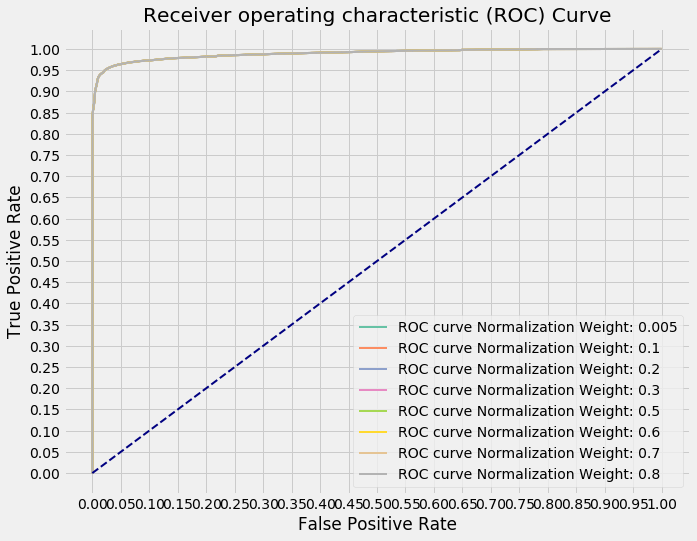

In [17]:
print(y.value_counts()) #Previous original class distribution
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Your response here  
Since SMOTE was done on the entire dataset, the test data is not real anymore

## Summary

In this lab, you got some hands-on practice tuning logistic regression models using various techniques and parameters. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.